### Documentation

The notebook performs the following operations:

1. **Scatter Plot Creation**:
  - A scatter plot is generated to visualize the relationship between the verification times of two tools, Kani and Seahorn.
  - The plot uses a logarithmic scale for both axes to better represent the wide range of verification times.

2. **Data Points Categorization**:
  - Points are categorized based on the results of the tools:
    - **Proofs (Both Passed)**: Represented in blue.
    - **Seahorn Failed**: Represented in brown with 'x' markers.
    - **Kani Failed**: Represented in orange with 'x' markers.

3. **Reference Line**:
  - A reference line `y = 10x` is added to the plot to compare the verification times of the two tools.

4. **Plot Customization**:
  - Titles, axis labels, and gridlines are added for better readability.
  - Custom ticks are set for the logarithmic scale.

5. **Legend**:
  - A legend is included to differentiate between the categories of points.

6. **Visualization**:
  - The plot is displayed using `plt.show()` to provide a clear visual representation of the data.


In [40]:
import pandas as pd

POSTPROCESS_CSV = 'benchmark_postprocess_eop.csv'
TIMEOUT = 1800 # 30 minutes

# Read the file into a pandas DataFrame
data = pd.read_csv(POSTPROCESS_CSV)



# Calculate and print the unique number of Test_Name and Test_Suite combinations
unique_combos = data.groupby(['Test_Name', 'Test_Suite']).ngroups
print(f"Number of tests: {unique_combos}")

# Display the first few rows of the DataFrame
data.head()

Number of tests: 83


,Test_Name,Test_Suite,Tool,Formula_Size,Solver_Time,Verification_Time,Wall_Time,Result
0,test_append,tinyvec-arrayvec,kani,1059,0.295374,2.792375,73.932610,pass
1,test_append,tinyvec-arrayvec,seahorn,158,0.020000,0.060000,3.926200,pass
2,testfail_append,tinyvec-arrayvec,kani,1088,0.402624,2.973078,13.984197,pass
3,testfail_append,tinyvec-arrayvec,seahorn,148,0.020000,0.050000,3.909926,pass
4,test_clear,tinyvec-arrayvec,kani,131,0.020733,0.429256,11.692493,pass


In [41]:
# Extract unique combinations of Test_Name and Test_Suite
unique_tests = data[['Test_Name', 'Test_Suite']].drop_duplicates()

# Use .loc to explicitly set the value
unique_tests.loc[:, 'Base_Test_Suite'] = unique_tests['Test_Suite'].str.split('-').str[0]

# Group by the Base_Test_Suite and count the number of unique tests in each suite
test_suite_counts = unique_tests.groupby('Base_Test_Suite').size().reset_index(name='Number_of_Tests')

# Display the table
print(test_suite_counts)

# Convert to LaTeX
latex_table = test_suite_counts.to_latex(index=False)  # index=False omits the row index in output
print(latex_table)


  Base_Test_Suite  Number_of_Tests
0          result                7
1             sea                9
2        smallvec               29
3         tinyvec               38
\begin{tabular}{lr}
\toprule
Base_Test_Suite & Number_of_Tests \\
\midrule
result & 7 \\
sea & 9 \\
smallvec & 29 \\
tinyvec & 38 \\
\bottomrule
\end{tabular}



Merge rows across tools for "Verification_Time". Also record 'pass', 'fail' result. If the result contains 'job timed out' then set tool run time to timeout value.

In [42]:
# Pivot the data to create a comparison view for Verification_Time
merged_data = data.pivot_table(
  index=["Test_Name", "Test_Suite"],
  columns="Tool",
  values="Verification_Time"
).reset_index()

# Add a column for each tool's result
merged_data["Tool_Result_kani"] = merged_data.apply(
  lambda row: data[(data["Test_Name"] == row["Test_Name"]) & 
           (data["Test_Suite"] == row["Test_Suite"]) & 
           (data["Tool"] == "kani")]["Result"].iloc[0], axis=1)

merged_data["Tool_Result_seahorn"] = merged_data.apply(
  lambda row: data[(data["Test_Name"] == row["Test_Name"]) & 
           (data["Test_Suite"] == row["Test_Suite"]) & 
           (data["Tool"] == "seahorn")]["Result"].iloc[0], axis=1)
# Rename the columns for clarity
merged_data.rename(
  columns={"kani": "Verification_Time_kani", "seahorn": "Verification_Time_seahorn"},
  inplace=True
)

# Update Verification_Time for 'job timed out' results
merged_data.loc[merged_data["Tool_Result_kani"].str.contains("job timed out", na=False), "Verification_Time_kani"] = TIMEOUT
merged_data.loc[merged_data["Tool_Result_seahorn"].str.contains("job timed out", na=False), "Verification_Time_seahorn"] = TIMEOUT

# Display the merged_data view
merged_data.head()

Tool,Test_Name,Test_Suite,Verification_Time_kani,Verification_Time_seahorn,Tool_Result_kani,Tool_Result_seahorn
0,entrypt,result-and_then,0.539696,0.03,pass,pass
1,entrypt,result-as_deref,0.069727,0.03,pass,pass
2,entrypt,result-cloned,0.175043,0.01,pass,pass
3,entrypt,result-copied,0.175967,0.02,pass,pass
4,entrypt,result-iter_mut,0.363536,0.02,pass,pass


See which of the jobs failed and why

In [43]:
# Filter rows where either Kani or Seahorn failed
failed_rows = merged_data[
  (merged_data["Tool_Result_kani"] != "pass") | (merged_data["Tool_Result_seahorn"] != "pass")
]

# Print the filtered rows
print(failed_rows)

Tool              Test_Name                  Test_Suite  \
13               test_drain  smallvec-allocation-bound2   
52              test_retain            tinyvec-arrayvec   
56              test_splice            tinyvec-arrayvec   
70     testfail_drain_panic            tinyvec-arrayvec   
79    testfail_splice_panic            tinyvec-arrayvec   

Tool  Verification_Time_kani  Verification_Time_seahorn  \
13                    1800.0                      19.03   
52                    1800.0                    1800.00   
56                    1800.0                     167.46   
70                    1800.0                       1.17   
79                    1800.0                     604.63   

Tool                                   Tool_Result_kani  \
13    fail: job error: [jobid=3426924] job timed out...   
52    fail: job error: [jobid=3511667] job timed out...   
56    fail: job error: [jobid=3410815] job timed out...   
70    fail: job error: [jobid=3401290] job timed out..

Now generate the scatter plot

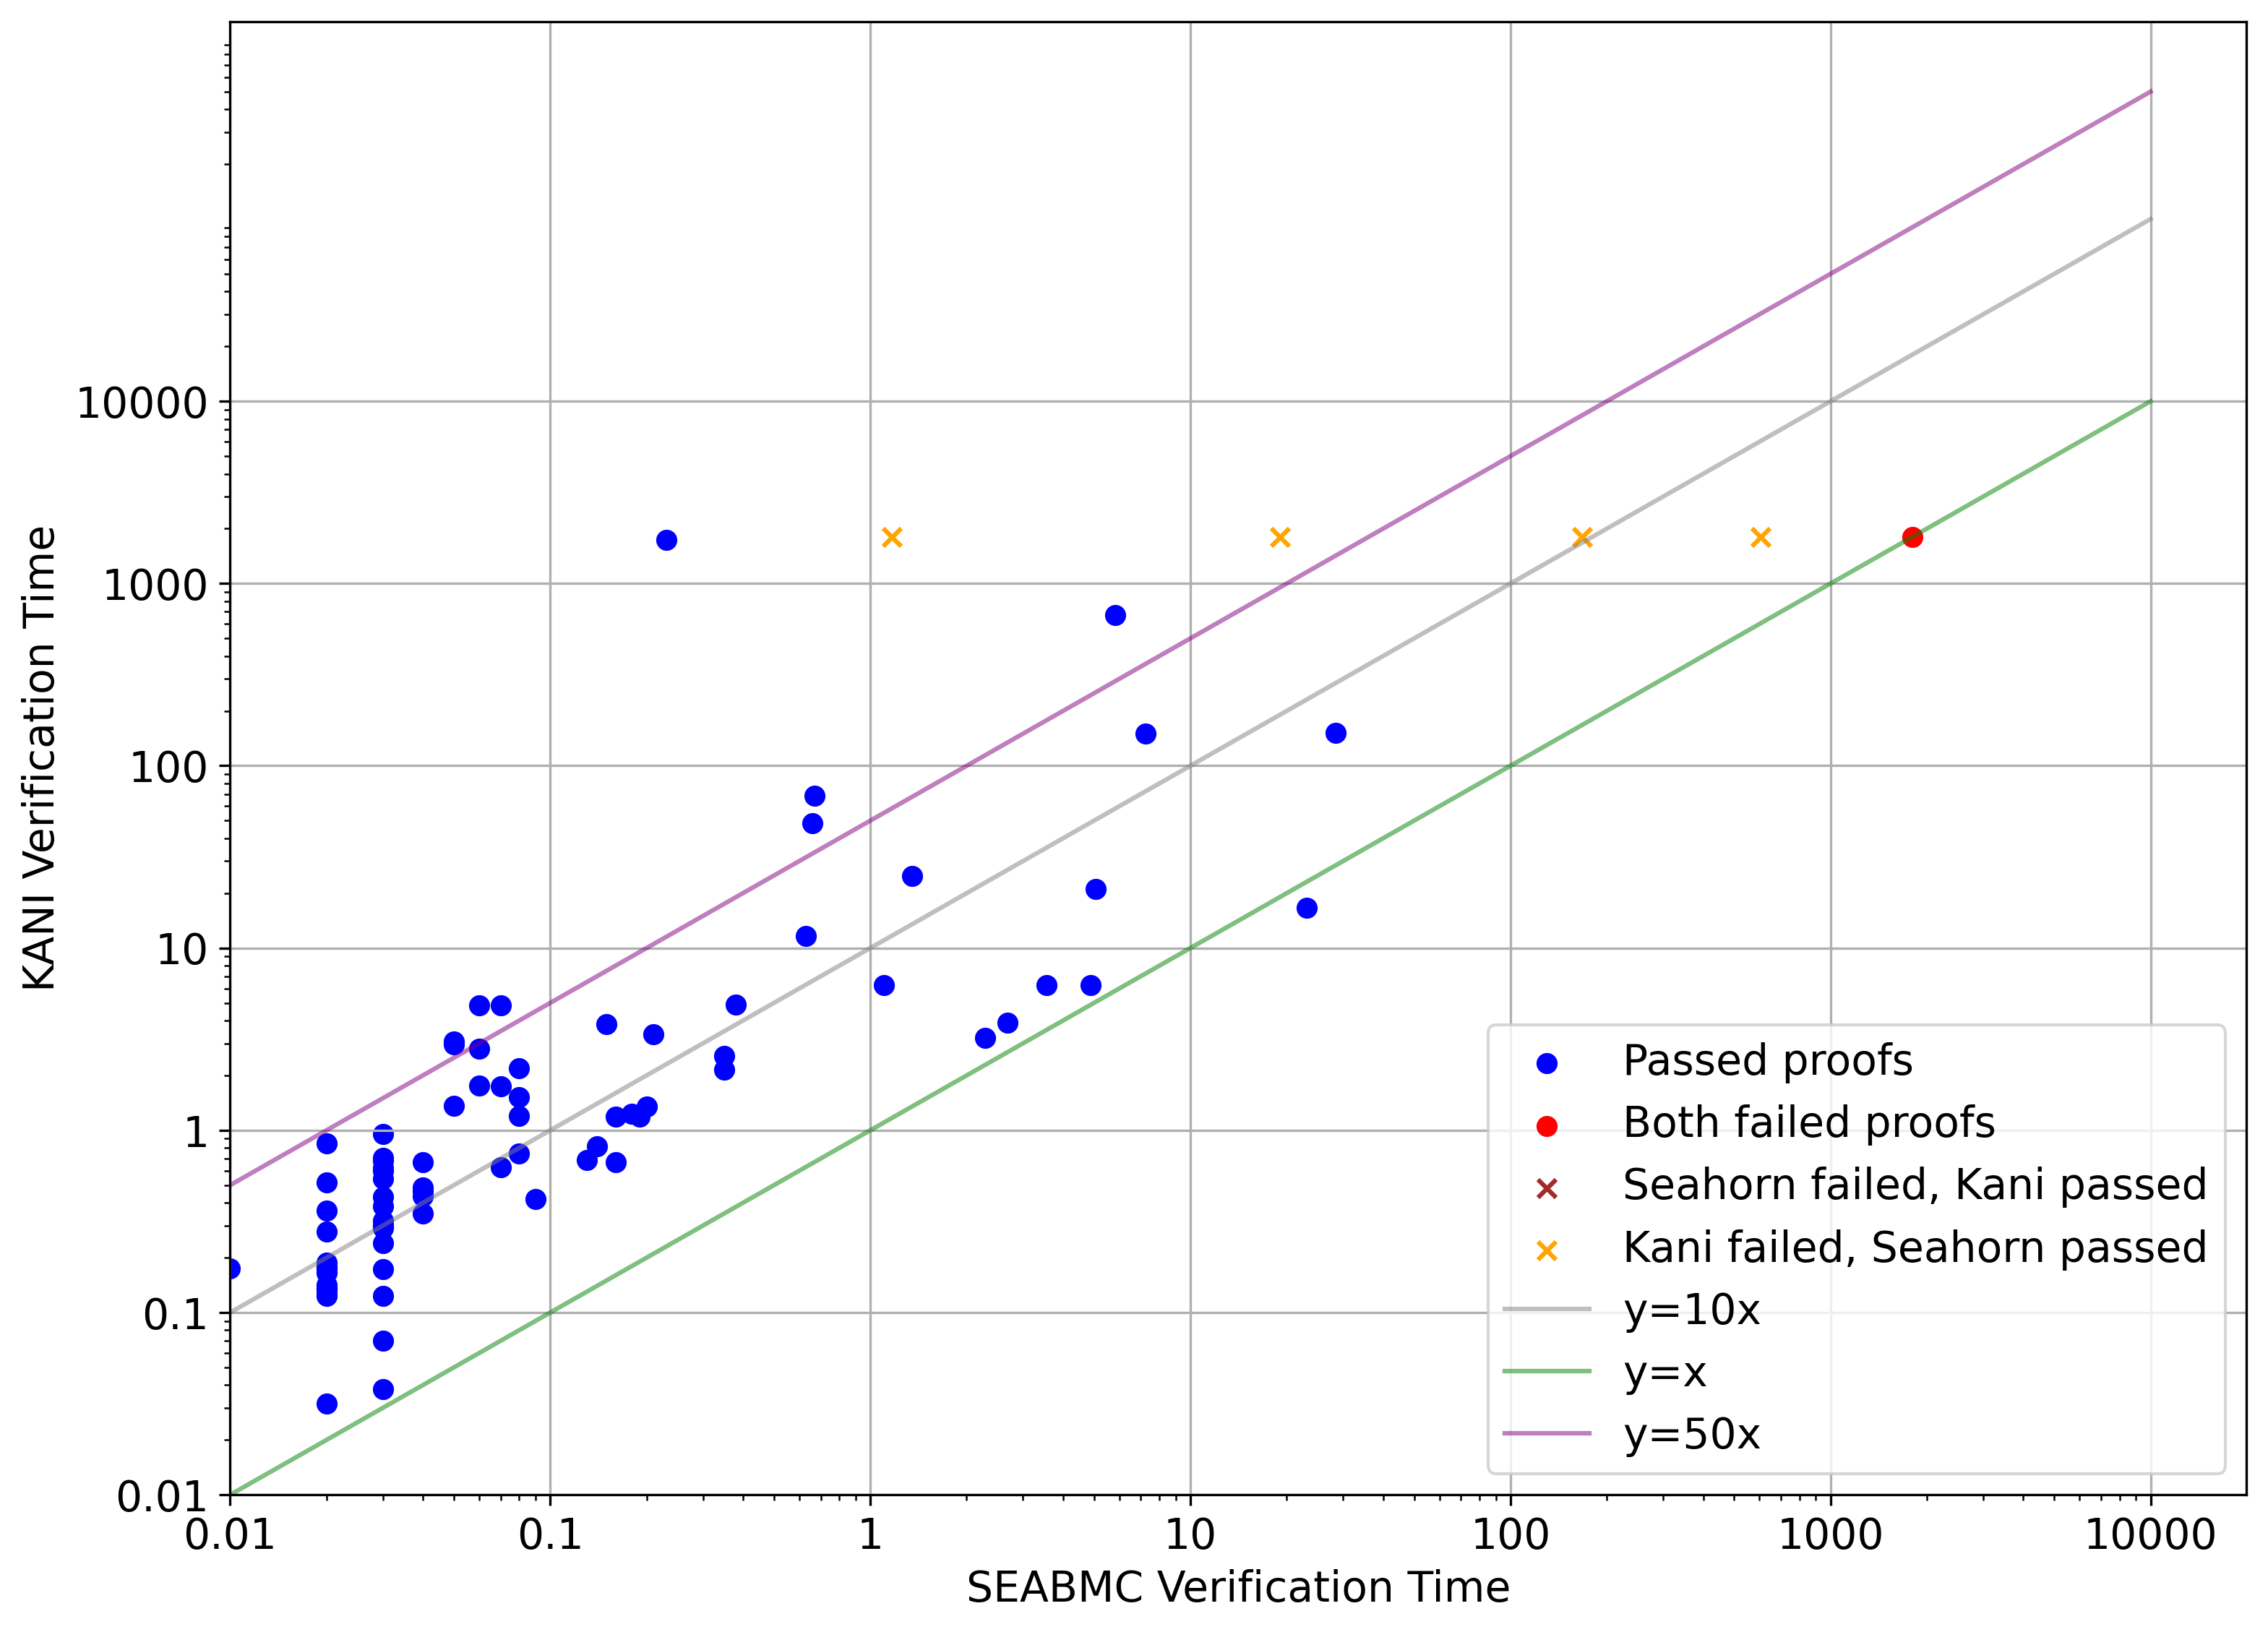

In [44]:
import matplotlib.pyplot as plt

# Set font size for the plot
plt.rcParams.update({'font.size': 14})  # Adjust the font size as needed

# Create the scatter plot with improved resolution
plt.figure(figsize=(12, 9), dpi=300)

# Plot points where both tools passed
passed_mask = (merged_data["Tool_Result_kani"] == "pass") & (merged_data["Tool_Result_seahorn"] == "pass")
plt.scatter(
  merged_data.loc[passed_mask, 'Verification_Time_seahorn'],
  merged_data.loc[passed_mask, 'Verification_Time_kani'],
  alpha=1.0, label='Passed proofs', color='blue'
)

# Plot points where both tools failed
both_failed_mask = (merged_data["Tool_Result_kani"] != "pass") & (merged_data["Tool_Result_seahorn"] != "pass")
plt.scatter(
  merged_data.loc[both_failed_mask, 'Verification_Time_seahorn'],
  merged_data.loc[both_failed_mask, 'Verification_Time_kani'],
  alpha=1.0, label='Both failed proofs', color='red', marker='o'
)

# Plot points where Seahorn failed and Kani passed
seahorn_failed_kani_passed_mask = (merged_data["Tool_Result_seahorn"] != "pass") & (merged_data["Tool_Result_kani"] == "pass")
plt.scatter(
  merged_data.loc[seahorn_failed_kani_passed_mask, 'Verification_Time_seahorn'],
  merged_data.loc[seahorn_failed_kani_passed_mask, 'Verification_Time_kani'],
  alpha=1.0, label='Seahorn failed, Kani passed', color='brown', marker='x'
)

# Plot points where Kani failed and Seahorn passed
kani_failed_seahorn_passed_mask = (merged_data["Tool_Result_kani"] != "pass") & (merged_data["Tool_Result_seahorn"] == "pass")
plt.scatter(
  merged_data.loc[kani_failed_seahorn_passed_mask, 'Verification_Time_seahorn'],
  merged_data.loc[kani_failed_seahorn_passed_mask, 'Verification_Time_kani'],
  alpha=1.0, label='Kani failed, Seahorn passed', color='orange', marker='x'
)
# Define x_vals and y_vals for the reference lines
x_vals = [1e-2, 1e4]  # Define the range for x-axis
# Draw the y=10x line
plt.plot(x_vals, [10 * i for i in x_vals], color='grey', alpha=0.5, label='y=10x')

# Draw the y=x line
plt.plot(x_vals, x_vals, color='green', alpha=0.5, label='y=x')

# Draw the y=50x line
plt.plot(x_vals, [50 * i for i in x_vals], color='purple', alpha=0.5, label='y=50x')

# Add labels and title
#plt.title('Scatter Plot of Verification Time (seconds): Seahorn vs Kani')
plt.xlabel('SEABMC Verification Time')
plt.ylabel('KANI Verification Time')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2, None)
plt.ylim(1e-2, None)

# Add custom ticks for log scale starting from 0
plt.xticks([1e-2, 1e-1, 1, 10, 100, 1000, 10000], ['0.01', '0.1', '1', '10', '100', '1000', '10000'])
plt.yticks([1e-2, 1e-1, 1, 10, 100, 1000, 10000], ['0.01', '0.1', '1', '10', '100', '1000', '10000'])

plt.grid(True)
plt.legend(loc='lower right')

# Save the plot to a PDF file before displaying it so that it is not blank
plt.savefig('verification_time.pdf', format='pdf', bbox_inches='tight') 

# Ensure the plot is displayed after saving
plt.show()

In [45]:
POSTPROCESS_AOP_CSV = 'benchmark_postprocess.csv'
# Read the data from POSTPROCESS_AOP_CSV
data_aop = pd.read_csv(POSTPROCESS_AOP_CSV)

# Compare the verification times for Seahorn in both datasets
comparison = pd.merge(
  data[data["Tool"] == "seahorn"][["Test_Name", "Test_Suite", "Verification_Time"]],
  data_aop[data_aop["Tool"] == "seahorn"][["Test_Name", "Test_Suite", "Verification_Time"]],
  on=["Test_Name", "Test_Suite"],
  suffixes=("_eop", "_aop")
)

# Display the comparison
comparison.head()

,Test_Name,Test_Suite,Verification_Time_eop,Verification_Time_aop
0,test_append,tinyvec-arrayvec,0.06,0.04
1,test_append,tinyvec-arrayvec,0.06,0.05
2,test_clear,tinyvec-arrayvec,0.03,0.03
3,test_clear,tinyvec-arrayvec,0.03,0.03
4,test_drain,tinyvec-arrayvec,0.23,0.22


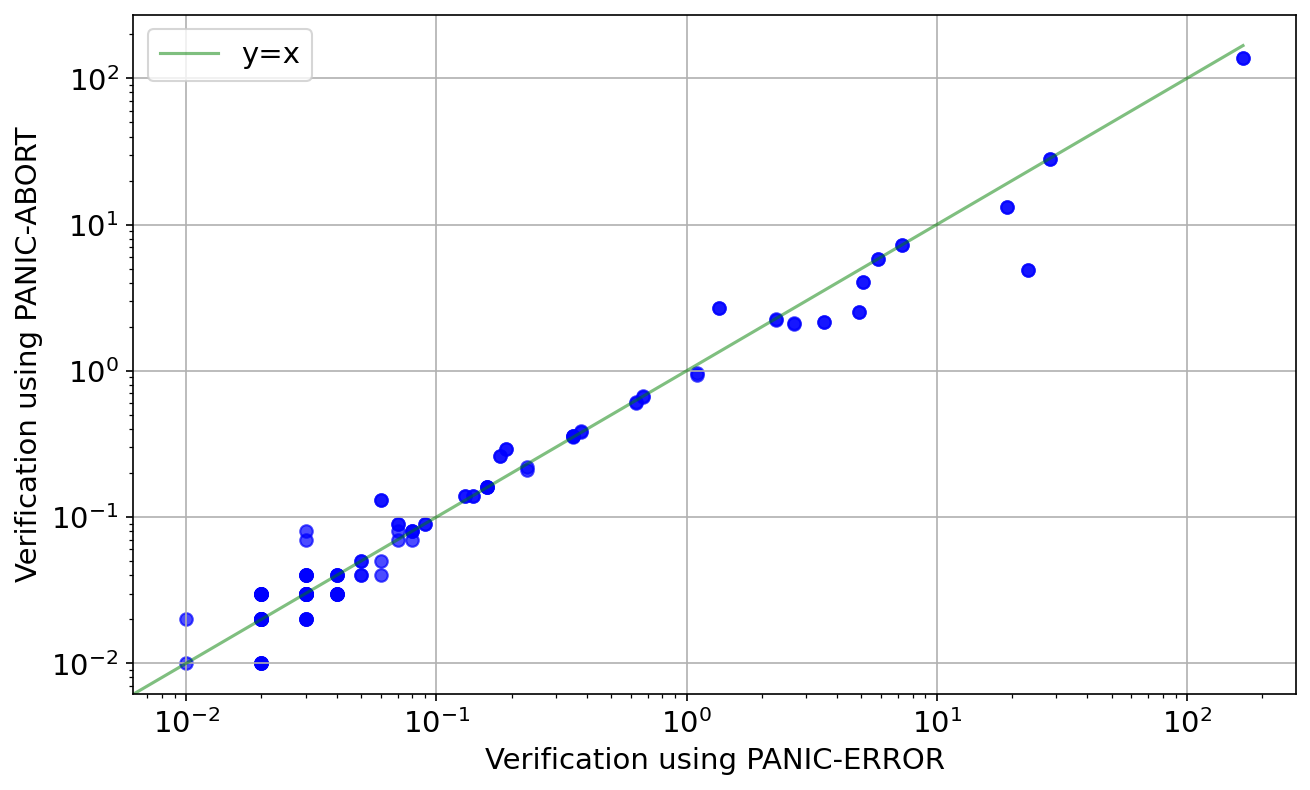

In [57]:
# Create a scatter plot for Seahorn verification times in both datasets
plt.figure(figsize=(10, 6), dpi=150)

plt.scatter(
  comparison["Verification_Time_eop"],
  comparison["Verification_Time_aop"],
  alpha=0.7, color='blue', label=''
)

# Add a reference line y=x
plt.plot([0, max(comparison["Verification_Time_eop"].max(), comparison["Verification_Time_aop"].max())],
     [0, max(comparison["Verification_Time_eop"].max(), comparison["Verification_Time_aop"].max())],
     color='green', label='y=x', alpha=0.5)

# Add labels, title, and legend
#plt.title('Scatter Plot of Seahorn Verification Times: EOP vs AOP')
plt.xlabel('Verification using PANIC-ERROR')
plt.ylabel('Verification using PANIC-ABORT')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()


# Save the plot to a PDF file before displaying it so that it is not blank
plt.savefig('aop_vs_eop_time.pdf', format='pdf', bbox_inches='tight') 

# Show the plot
plt.show()

In [47]:
# Calculate the percentage difference between EOP and AOP verification times
comparison['Percentage_Difference'] = ((comparison['Verification_Time_eop']) / comparison['Verification_Time_aop'])

# Calculate the average percentage difference
average_difference = comparison['Percentage_Difference'].mean()

# Determine which is faster on average
if average_difference > 0:
  print(f"Seahorn AOP is faster on average by {average_difference:.2f}x.")
else:
  print(f"Seahorn EOP is faster on average by {abs(average_difference):.2f}x.")

Seahorn AOP is faster on average by 1.09x.


Find the average running of Kani and Seahorn (EOP) unit proofs that passed

In [48]:
# Filter rows where both Kani and Seahorn passed
passed_jobs = merged_data[
  (merged_data["Tool_Result_kani"] == "pass") & (merged_data["Tool_Result_seahorn"] == "pass")
]

# Calculate the average running time for jobs that passed in both Kani and Seahorn
average_time_passed_kani = passed_jobs["Verification_Time_kani"].mean()
average_time_passed_seahorn = passed_jobs["Verification_Time_seahorn"].mean()

print(f"Average running time of Kani for passed jobs: {average_time_passed_kani:.2f} seconds")
print(f"Average running time of Seahorn for passed jobs: {average_time_passed_seahorn:.2f} seconds")

Average running time of Kani for passed jobs: 38.27 seconds
Average running time of Seahorn for passed jobs: 1.18 seconds


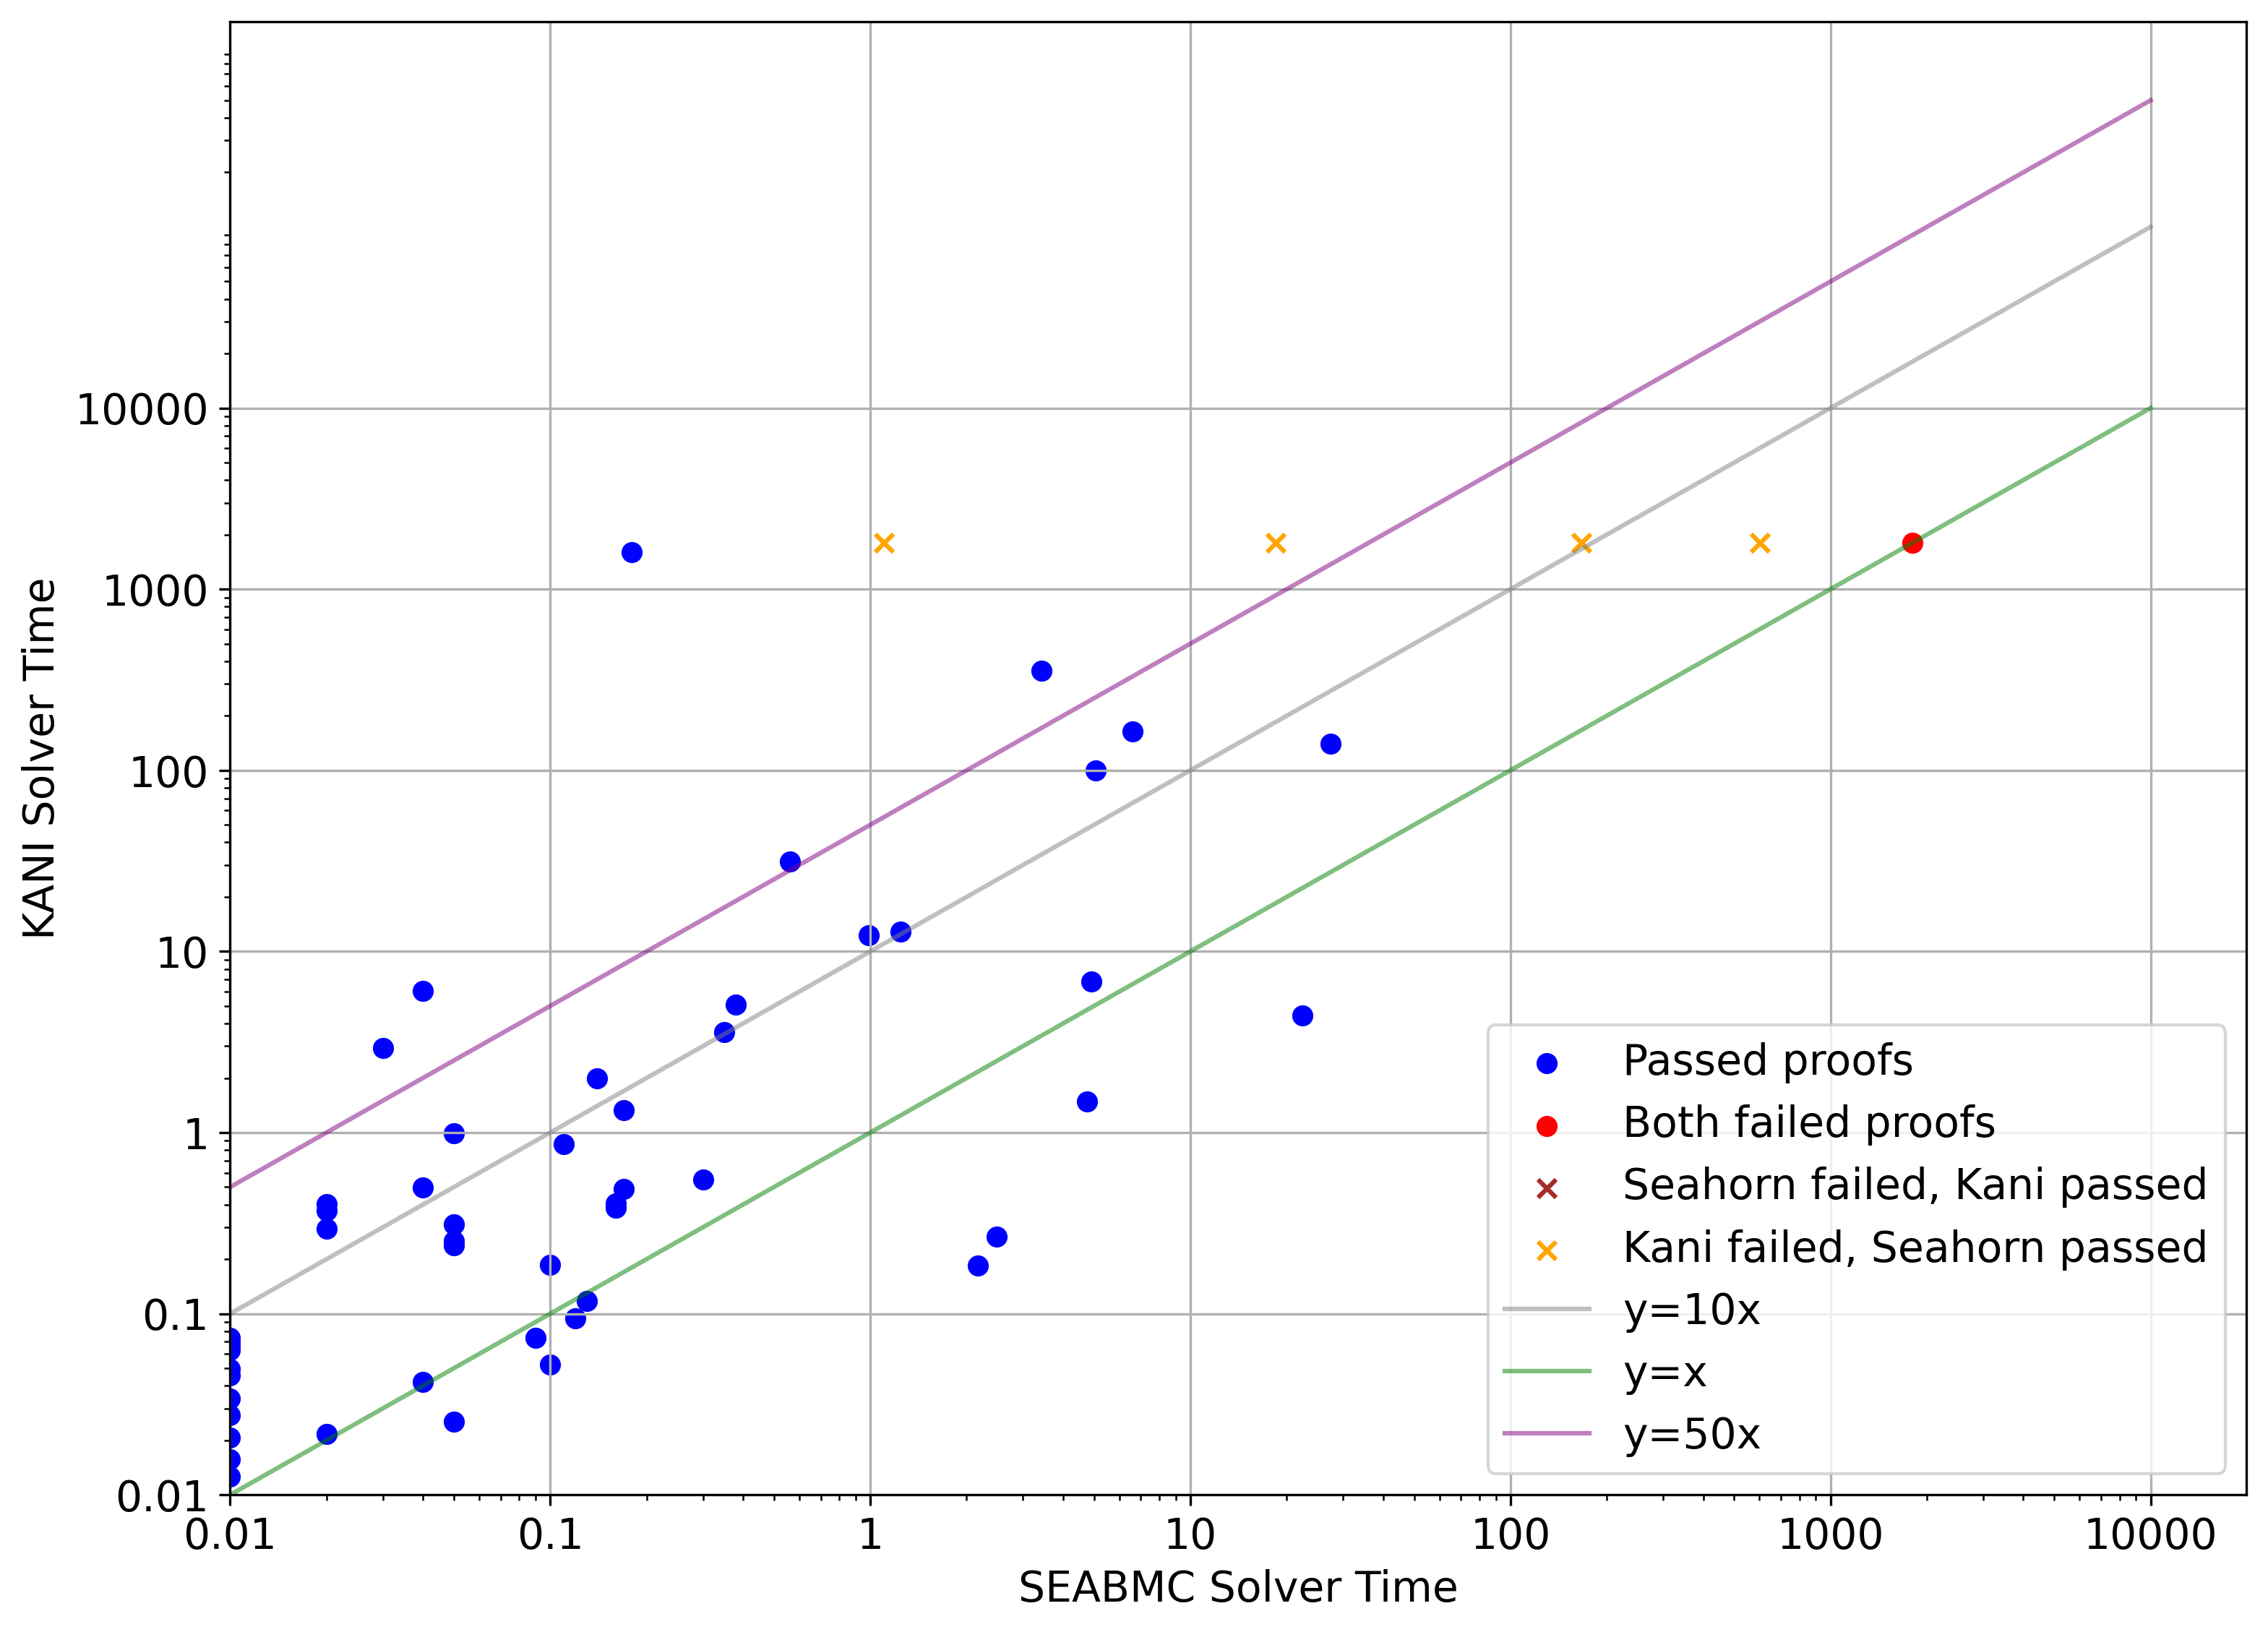

In [49]:
import matplotlib.pyplot as plt

# Pivot the data to create a comparison view for Solver_Time
merged_solve_data = data.pivot_table(
  index=["Test_Name", "Test_Suite"],
  columns="Tool",
  values="Solver_Time"
).reset_index()

# Add a column for each tool's result
merged_solve_data["Tool_Result_kani"] = merged_solve_data.apply(
  lambda row: data[(data["Test_Name"] == row["Test_Name"]) & 
           (data["Test_Suite"] == row["Test_Suite"]) & 
           (data["Tool"] == "kani")]["Result"].iloc[0], axis=1)

merged_solve_data["Tool_Result_seahorn"] = merged_solve_data.apply(
  lambda row: data[(data["Test_Name"] == row["Test_Name"]) & 
           (data["Test_Suite"] == row["Test_Suite"]) & 
           (data["Tool"] == "seahorn")]["Result"].iloc[0], axis=1)

# Rename the columns for clarity
merged_solve_data.rename(
  columns={"kani": "Solver_Time_kani", "seahorn": "Solver_Time_seahorn"},
  inplace=True
)

# Update Solver_Time for 'job timed out' results
merged_solve_data.loc[merged_data["Tool_Result_kani"].str.contains("job timed out", na=False), "Solver_Time_kani"] = TIMEOUT
merged_solve_data.loc[merged_data["Tool_Result_seahorn"].str.contains("job timed out", na=False), "Solver_Time_seahorn"] = TIMEOUT

# Set font size for the plot
plt.rcParams.update({'font.size': 14})  # Adjust the font size as needed

# Create the scatter plot with improved resolution
plt.figure(figsize=(12, 9), dpi=300)

# Plot points where both tools passed
passed_mask = (merged_solve_data["Tool_Result_kani"] == "pass") & (merged_solve_data["Tool_Result_seahorn"] == "pass")
plt.scatter(
  merged_solve_data.loc[passed_mask, 'Solver_Time_seahorn'],
  merged_solve_data.loc[passed_mask, 'Solver_Time_kani'],
  alpha=1.0, label='Passed proofs', color='blue'
)

# Plot points where both tools failed
both_failed_mask = (merged_solve_data["Tool_Result_kani"] != "pass") & (merged_data["Tool_Result_seahorn"] != "pass")
plt.scatter(
  merged_solve_data.loc[both_failed_mask, 'Solver_Time_seahorn'],
  merged_solve_data.loc[both_failed_mask, 'Solver_Time_kani'],
  alpha=1.0, label='Both failed proofs', color='red', marker='o'
)

# Plot points where Seahorn failed and Kani passed
seahorn_failed_kani_passed_mask = (merged_data["Tool_Result_seahorn"] != "pass") & (merged_solve_data["Tool_Result_kani"] == "pass")
plt.scatter(
  merged_solve_data.loc[seahorn_failed_kani_passed_mask, 'Solver_Time_seahorn'],
  merged_solve_data.loc[seahorn_failed_kani_passed_mask, 'Solver_Time_kani'],
  alpha=1.0, label='Seahorn failed, Kani passed', color='brown', marker='x'
)

# Plot points where Kani failed and Seahorn passed
kani_failed_seahorn_passed_mask = (merged_data["Tool_Result_kani"] != "pass") & (merged_solve_data["Tool_Result_seahorn"] == "pass")
plt.scatter(
  merged_solve_data.loc[kani_failed_seahorn_passed_mask, 'Solver_Time_seahorn'],
  merged_solve_data.loc[kani_failed_seahorn_passed_mask, 'Solver_Time_kani'],
  alpha=1.0, label='Kani failed, Seahorn passed', color='orange', marker='x'
)

# Define x_vals and y_vals for the reference lines
x_vals = [1e-2, 1e4]  # Define the range for x-axis
# Draw the y=10x line
plt.plot(x_vals, [10 * i for i in x_vals], color='grey', alpha=0.5, label='y=10x')

# Draw the y=x line
plt.plot(x_vals, x_vals, color='green', alpha=0.5, label='y=x')

# Draw the y=50x line
plt.plot(x_vals, [50 * i for i in x_vals], color='purple', alpha=0.5, label='y=50x')

# Add labels and title
plt.xlabel('SEABMC Solver Time')
plt.ylabel('KANI Solver Time')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2, None)
plt.ylim(1e-2, None)

# Add custom ticks for log scale starting from 0
plt.xticks([1e-2, 1e-1, 1, 10, 100, 1000, 10000], ['0.01', '0.1', '1', '10', '100', '1000', '10000'])
plt.yticks([1e-2, 1e-1, 1, 10, 100, 1000, 10000], ['0.01', '0.1', '1', '10', '100', '1000', '10000'])

plt.grid(True)
plt.legend(loc='lower right')

# Save the plot to a PDF file before displaying it so that it is not blank
plt.savefig('solver_time.pdf', format='pdf', bbox_inches='tight') 

# Ensure the plot is displayed after saving
plt.show()

In [50]:
# Filter rows where SEABMC solver time is greater than KANI solver time
seabmc_greater_than_kani = merged_solve_data[merged_solve_data["Solver_Time_seahorn"] > merged_solve_data["Solver_Time_kani"]]

# Select and display the Test_Name and Test_Suite columns
result = seabmc_greater_than_kani[["Test_Name", "Test_Suite"]]
print(result)

Tool                Test_Name                  Test_Suite
1                     entrypt             result-as_deref
2                     entrypt               result-cloned
3                     entrypt               result-copied
7                 test_append  smallvec-allocation-bound2
9                  test_clear                    smallvec
12                 test_drain                     sea-vec
32           test_insert_many  smallvec-allocation-bound2
33         test_insert_remove                     sea-vec
35                test_macros                     sea-vec
44               test_reserve                    smallvec
51          test_resize_with2  smallvec-allocation-bound2
55         test_shrink_to_fit  smallvec-allocation-bound2
72    testfail_from_array_len            tinyvec-arrayvec


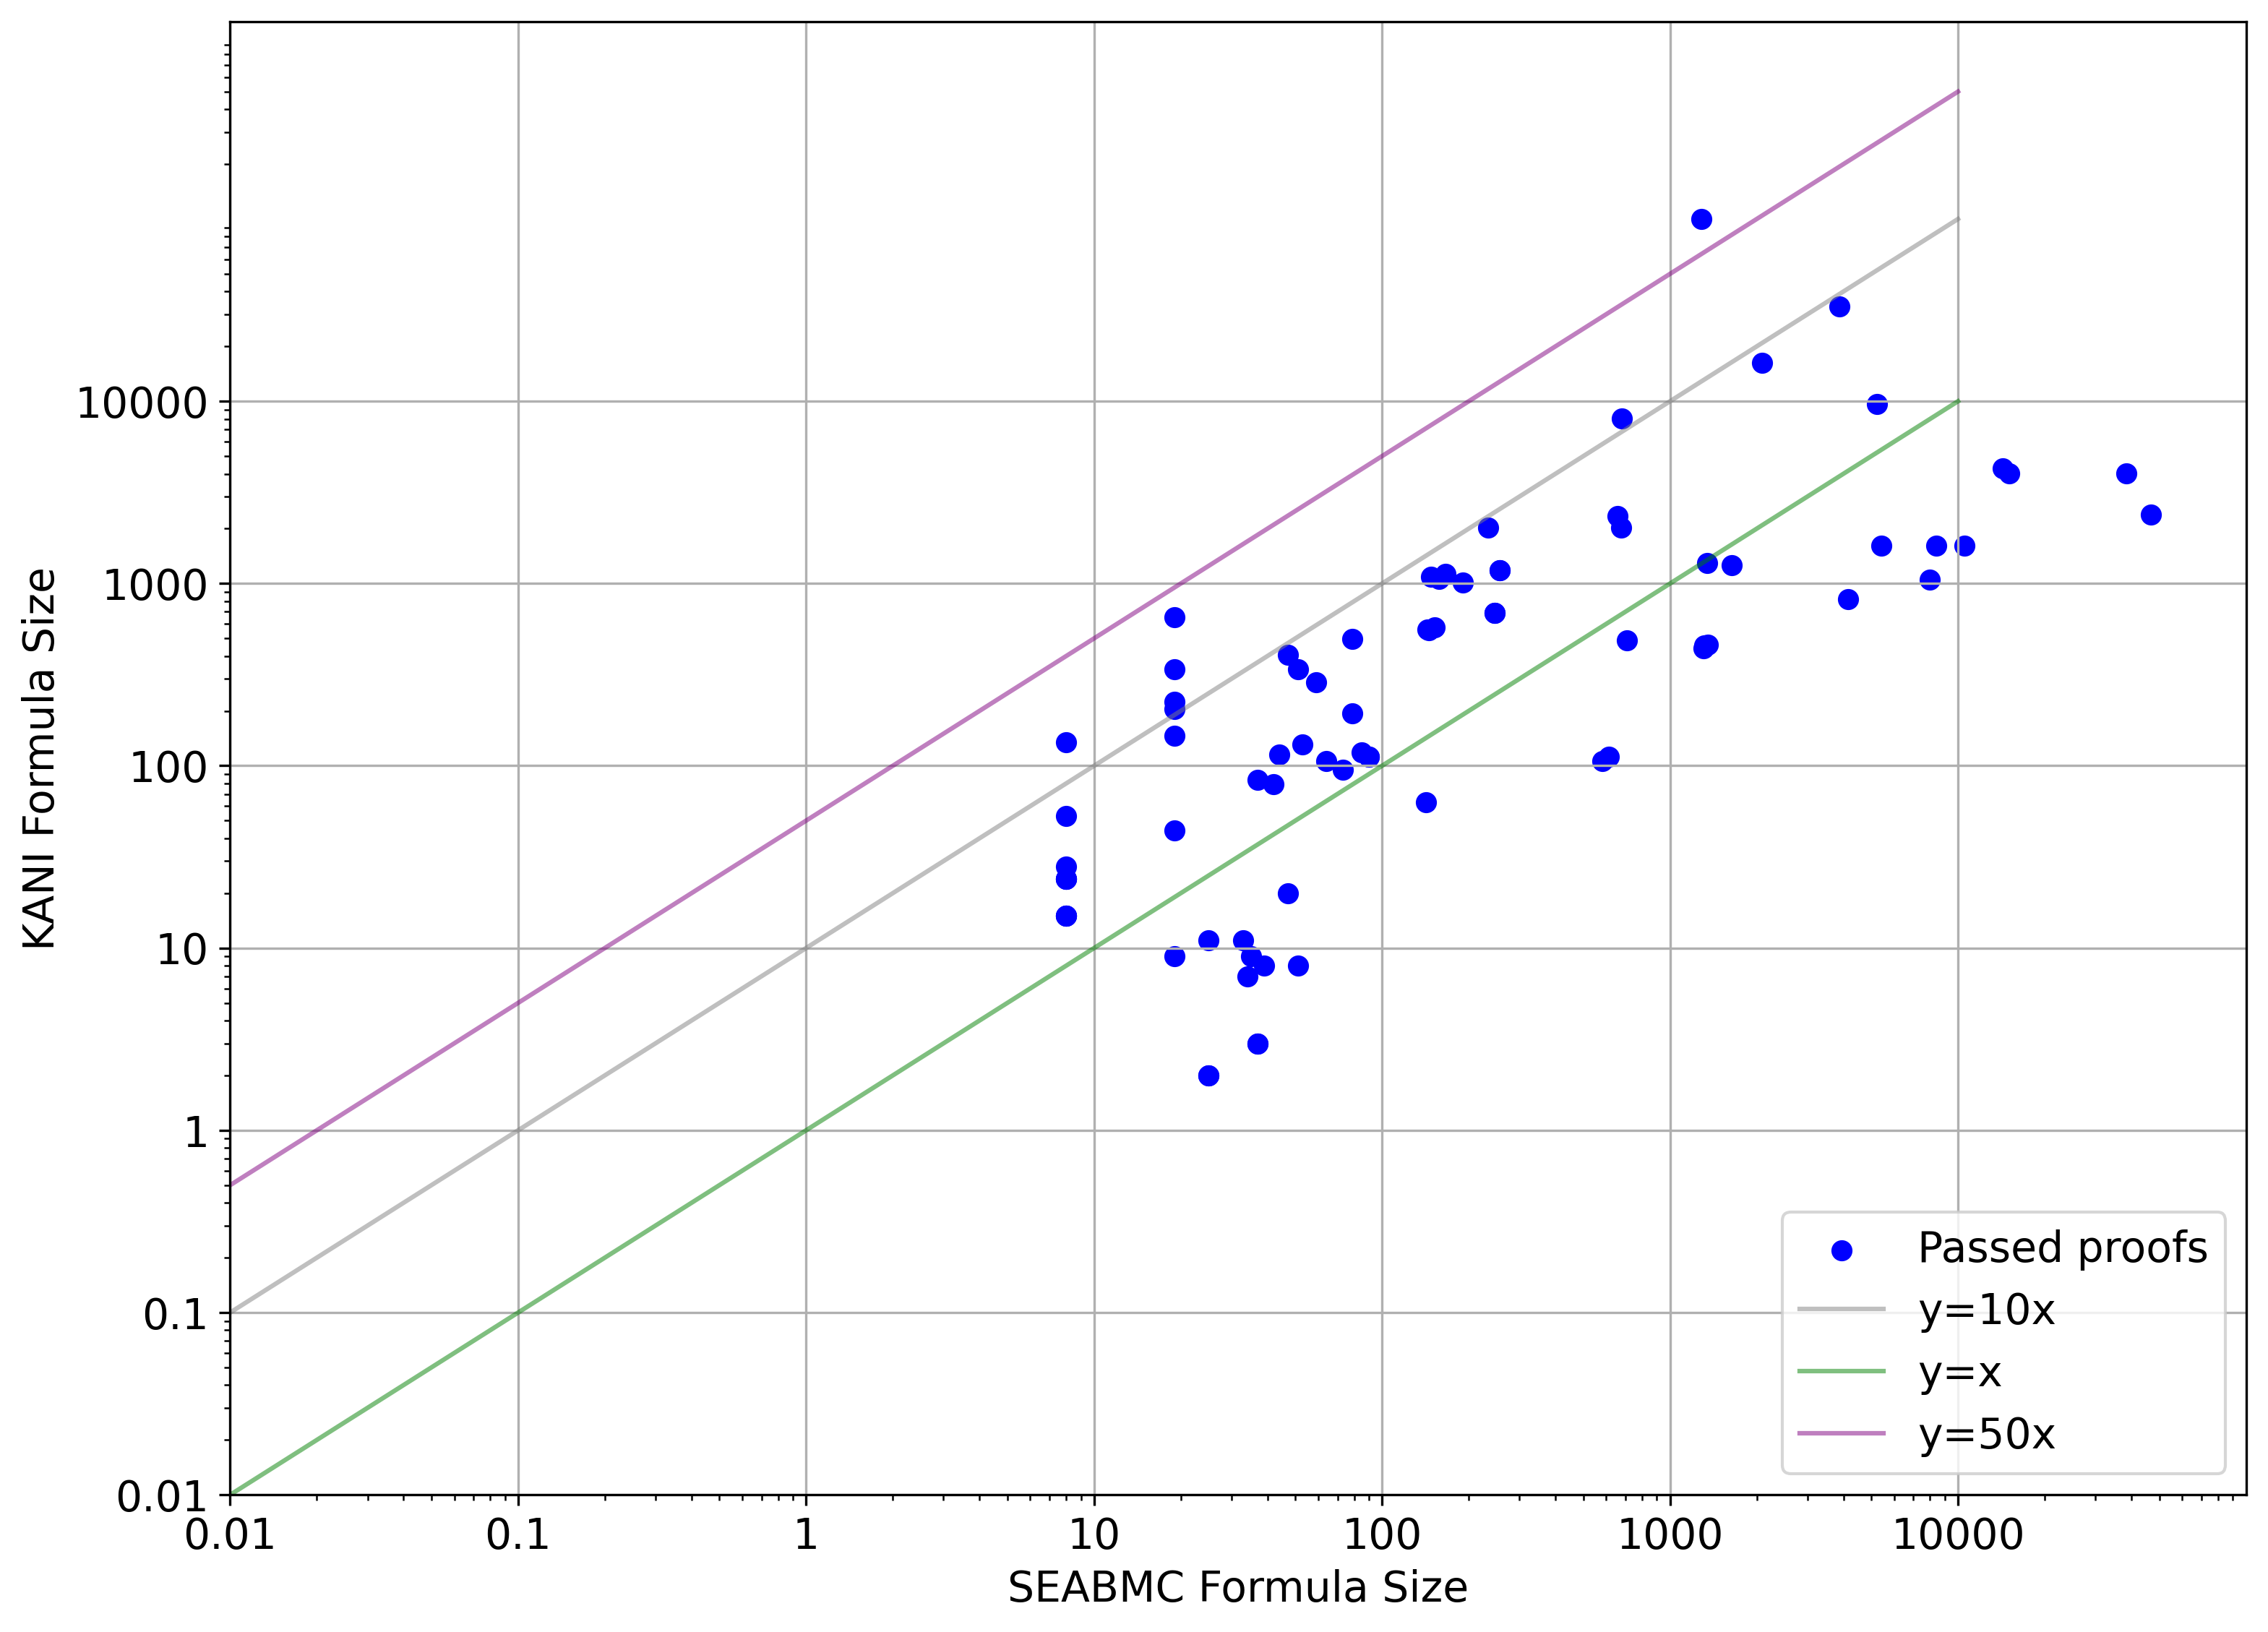

In [51]:
# Filter the data to include only jobs that pass in both tools
filtered_data = merged_formula_size_data[passed_mask]

# Set font size for the plot
plt.rcParams.update({'font.size': 14})  # Adjust the font size as needed

# Create the scatter plot with improved resolution
plt.figure(figsize=(12, 9), dpi=300)

# Plot points where both tools passed
plt.scatter(
  filtered_data['Formula_Size_seahorn'],
  filtered_data['Formula_Size_kani'],
  alpha=1.0, label='Passed proofs', color='blue'
)

# Define x_vals and y_vals for the reference lines
x_vals = [1e-2, 1e4]  # Define the range for x-axis
# Draw the y=10x line
plt.plot(x_vals, [10 * i for i in x_vals], color='grey', alpha=0.5, label='y=10x')

# Draw the y=x line
plt.plot(x_vals, x_vals, color='green', alpha=0.5, label='y=x')

# Draw the y=50x line
plt.plot(x_vals, [50 * i for i in x_vals], color='purple', alpha=0.5, label='y=50x')

# Add labels and title
plt.xlabel('SEABMC Formula Size')
plt.ylabel('KANI Formula Size')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2, None)
plt.ylim(1e-2, None)

# Add custom ticks for log scale starting from 0
plt.xticks([1e-2, 1e-1, 1, 10, 100, 1000, 10000], ['0.01', '0.1', '1', '10', '100', '1000', '10000'])
plt.yticks([1e-2, 1e-1, 1, 10, 100, 1000, 10000], ['0.01', '0.1', '1', '10', '100', '1000', '10000'])

plt.grid(True)
plt.legend(loc='lower right')

# Save the plot to a PDF file before displaying it so that it is not blank
plt.savefig('formula_size_filtered.pdf', format='pdf', bbox_inches='tight') 

# Ensure the plot is displayed after saving
plt.show()
